<a href="https://colab.research.google.com/github/AkashSinghrajpoot/data_anylysis/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Merged columns: ['timestamp', 'value', 'classification', 'date_x', 'account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'date_y']

Correlation between sentiment and closed PnL:
               value  closed pnl
value       1.000000    0.311405
closed pnl  0.311405    1.000000


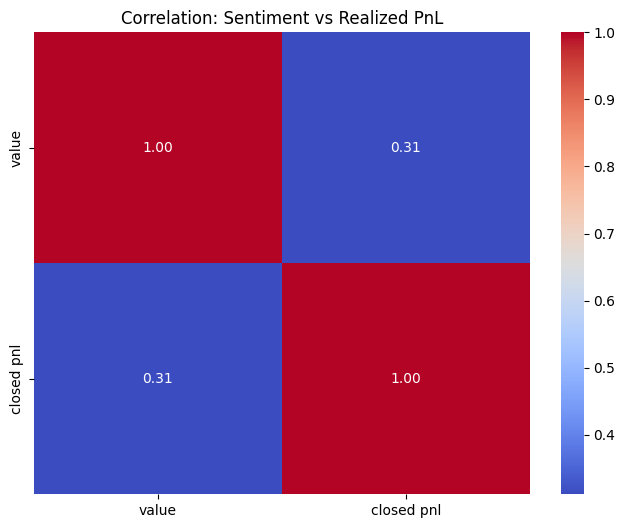


Average Closed PnL by sentiment classification:
classification
Extreme Fear             NaN
Extreme Greed       0.000000
Fear                0.000000
Greed            4240.282964
Neutral             0.000000
Name: closed pnl, dtype: float64


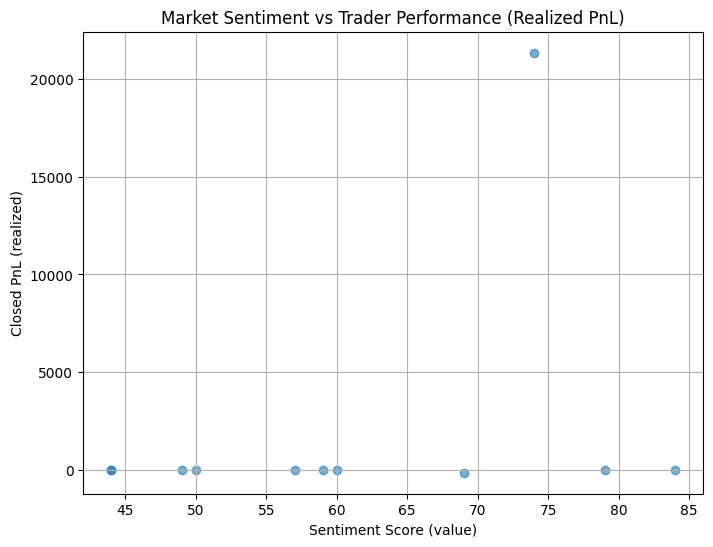

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Load datasets ----------
trades = pd.read_csv("/content/fear_greed_index.csv")
sentiment = pd.read_csv(r"/content/historical_data (1).csv", dtype={'Column_12_Name': str})

# Normalize column names
trades.columns = trades.columns.str.strip().str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

# ---------- 2. Timestamp cleaning function (with deprecation fix) ----------
def clean_timestamp(df, col_name, fill_method='ffill', prefer_ms=None, drop_rows_with_na_ts=False):
    if col_name not in df.columns:
        raise KeyError(f"Column '{col_name}' not found")
    df = df.copy()
    s = df[col_name]
    non_null = s.dropna()
    if non_null.empty:
        df[col_name] = pd.to_datetime(s, errors='coerce')
    else:
        sample = non_null.iloc[0]
        if pd.api.types.is_datetime64_any_dtype(s) or isinstance(sample, pd.Timestamp):
            df[col_name] = pd.to_datetime(s, errors='coerce')
        else:
            numeric = pd.to_numeric(s, errors='coerce')
            if numeric.dropna().shape[0] >= 0.5 * len(s):
                first = numeric.dropna().iloc[0]
                unit = 'ms' if (prefer_ms if prefer_ms is not None else abs(first) > 1e11) else 's'
                df[col_name] = pd.to_datetime(numeric, unit=unit, errors='coerce')
            else:
                df[col_name] = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)

    df['date'] = df[col_name].dt.date
    if fill_method == 'ffill':
        df['date'] = df['date'].ffill()
    elif fill_method == 'bfill':
        df['date'] = df['date'].bfill()
    if drop_rows_with_na_ts:
        df = df.dropna(subset=[col_name])
    return df

# ---------- 3. Apply cleaning ----------
ts_col = 'timestamp' if trades['timestamp'].notna().sum() > 0 else 'timestamp ist'
trades_clean = clean_timestamp(trades, ts_col, fill_method='ffill')
sentiment_clean = clean_timestamp(sentiment, 'timestamp', fill_method='ffill')

# ---------- 4. Sort datasets for merge_asof ----------
trades_clean = trades_clean.sort_values('timestamp')
sentiment_clean = sentiment_clean.sort_values('timestamp')

# ---------- 5. Nearest-time merge with tolerance ----------
merged = pd.merge_asof(
    trades_clean,
    sentiment_clean,
    on='timestamp',
    direction='nearest',
    tolerance=pd.Timedelta('1D')
)

# Drop rows where sentiment was not matched
merged = merged.dropna(subset=['value'])

print("Merged columns:", merged.columns.tolist())
print(merged)

# ---------- 6. Step 3: Correlation Analysis (using 'closed pnl') ----------
if 'value' in merged.columns and 'closed pnl' in merged.columns:
    corr_matrix = merged[['value', 'closed pnl']].corr()
    print("\nCorrelation between sentiment and closed PnL:")
    print(corr_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation: Sentiment vs Realized PnL")
    plt.show()
else:
    print("Required columns for correlation ('value', 'closed pnl') not found.")

# ---------- 7. Step 4a: Group-level average PnL ----------
if 'classification' in merged.columns and 'closed pnl' in merged.columns:
    group_means = merged.groupby('classification')['closed pnl'].mean()
    print("\nAverage Closed PnL by sentiment classification:")
    print(group_means)

# ---------- 8. Step 4b: Scatter Plot ----------
if 'value' in merged.columns and 'closed pnl' in merged.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(merged['value'], merged['closed pnl'], alpha=0.6)
    plt.xlabel("Sentiment Score (value)")
    plt.ylabel("Closed PnL (realized)")
    plt.title("Market Sentiment vs Trader Performance (Realized PnL)")
    plt.grid(True)
    plt.show()
